## Section 0 - Imports

In [1]:
# %matplotlib qt
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy import ndimage
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.manifold import TSNE
from skimage.color import lab2rgb , rgb2lab

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from matplotlib.colors import ListedColormap

import copy
import time

from openTSNE import TSNE as opTSNE


'''
import matplotlib
import scipy
import sklearn
import skimage
import mpl_toolkits
import openTSNE
'''

'\nimport matplotlib\nimport scipy\nimport sklearn\nimport skimage\nimport mpl_toolkits\nimport openTSNE\n'

In [2]:
'''


print("numpy = " + np.__version__)
print("matplotlib = " + matplotlib.__version__)
print("h5py = " + h5py.__version__)
print("scipy = " + scipy.__version__)
print("pandas = " + pd.__version__)
print("sklearn = " + sklearn.__version__)
print("skimage = " + skimage.__version__)
print("seaborn = " + sns.__version__)
print("openTSNE = " + openTSNE.__version__)

'''

'\n\n\nprint("numpy = " + np.__version__)\nprint("matplotlib = " + matplotlib.__version__)\nprint("h5py = " + h5py.__version__)\nprint("scipy = " + scipy.__version__)\nprint("pandas = " + pd.__version__)\nprint("sklearn = " + sklearn.__version__)\nprint("skimage = " + skimage.__version__)\nprint("seaborn = " + sns.__version__)\nprint("openTSNE = " + openTSNE.__version__)\n\n'

## Section 1 - Data Preparation

In [3]:
h5 = h5py.File('GastricData.mat', 'r')

#print(list(h5.keys()))

# Get all data variables and store them

# Clinical_data not read correctly, read by CSV
#Clinical_data= h5.get('Clinical_data')[:]

HE_image= h5.get('HE_image')[:]
HE_image = HE_image.swapaxes(0,2)


MSI_data_cube= h5.get('MSI_data_cube')[:]
MSI_data_cube = MSI_data_cube.swapaxes(0,2)

goodlist= h5.get('goodlist')[:]
goodlist = goodlist.swapaxes(0,1)

peak_list= h5.get('peak_list')[:]
peak_list = peak_list.swapaxes(0,1)

pixel_to_sample_ID= h5.get('pixel_to_sample_ID')[:]
pixel_to_sample_ID = pixel_to_sample_ID.swapaxes(0,1)  

h5.close()

# Clinical_data = pd.read_excel('ClinicalData.xlsx')

height , width = (pixel_to_sample_ID.shape) # ( 443 , 1653 )

flattened_MSI_data_cube = MSI_data_cube.flatten().reshape(MSI_data_cube.shape[0] * MSI_data_cube.shape[1] , MSI_data_cube.shape[2])

# The scaler object (model)
scaler = StandardScaler()
# fit and transform the data
scaled_data = scaler.fit_transform(flattened_MSI_data_cube) 

flattened_pixel_to_sample_ID = pixel_to_sample_ID.flatten() 

indices = np.where(flattened_pixel_to_sample_ID == -1)
indices_sampleID = np.where(flattened_pixel_to_sample_ID == -1 )

In [4]:
Sample_1 = 1
Sample_2 = 18
Sample_3 = 59

In [5]:
sample_only_scaled_data = np.delete(scaled_data, indices[0] , axis=0)
sample_ID_pixels = np.delete(flattened_pixel_to_sample_ID , indices_sampleID[0] , axis=0)
original_sample_ID_pixels = copy.deepcopy(sample_ID_pixels)

# Pick 3 samples
mask = (sample_ID_pixels == Sample_1 ) 
samples_selected = sample_ID_pixels
samples_selected[mask] = 100

mask = (sample_ID_pixels == Sample_2 ) 
samples_selected[mask] = 200

mask = (sample_ID_pixels == Sample_3 ) 
samples_selected[mask] = 300

# Make other samples the same low intensity color
mask = (sample_ID_pixels <= 63) 
samples_selected[mask] = 1

## Section 2 - PCA

In [6]:
pca = PCA(n_components=5)
pca_result = pca.fit_transform(sample_only_scaled_data)

pca_df = pd.DataFrame(data=pca_result[:],columns=["PC1","PC2","PC3","PC4","PC5"])
print('Explained variation per PC: {}'.format(pca.explained_variance_ratio_))
variance = pca.explained_variance_ratio_

Explained variation per PC: [0.17506106 0.09651383 0.06742341 0.0467137  0.04414016]


Text(0, 0.5, 'Variance Percentage')

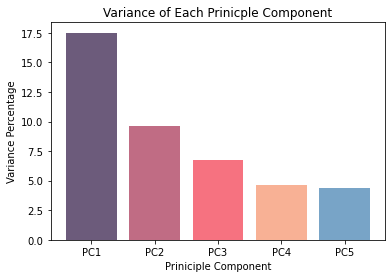

In [7]:
PCA=["PC1","PC2","PC3","PC4","PC5"]

COLORS = ["#6C5B7B","#C06C84","#F67280","#F8B195", "#78a4c7"]

plt.bar(PCA, variance*100, color=COLORS)

plt.title('Variance of Each Prinicple Component')
plt.xlabel('Priniciple Component')
plt.ylabel('Variance Percentage')

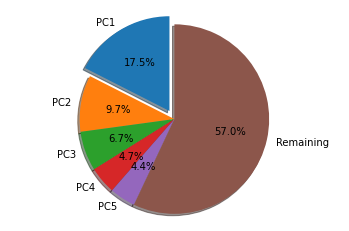

Variance Represented by PCA = 42.99 %


In [8]:
# Pie chart
labels = 'PC1', 'PC2', 'PC3', 'PC4' , 'PC5' , 'Remaining'
sizes = [ variance[0], variance[1], variance[2], variance[3] , variance[4] , 1 - ( variance[0] + variance[1] + variance[2] + variance[3] + variance[4] )  ]
explode = (0.1, 0, 0, 0, 0, 0) 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, normalize=False)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()
print('Variance Represented by PCA = ' + str(round((variance[0] + variance[1] + variance[2] + variance[3] + variance[4])*100 , 2) ) +' %')

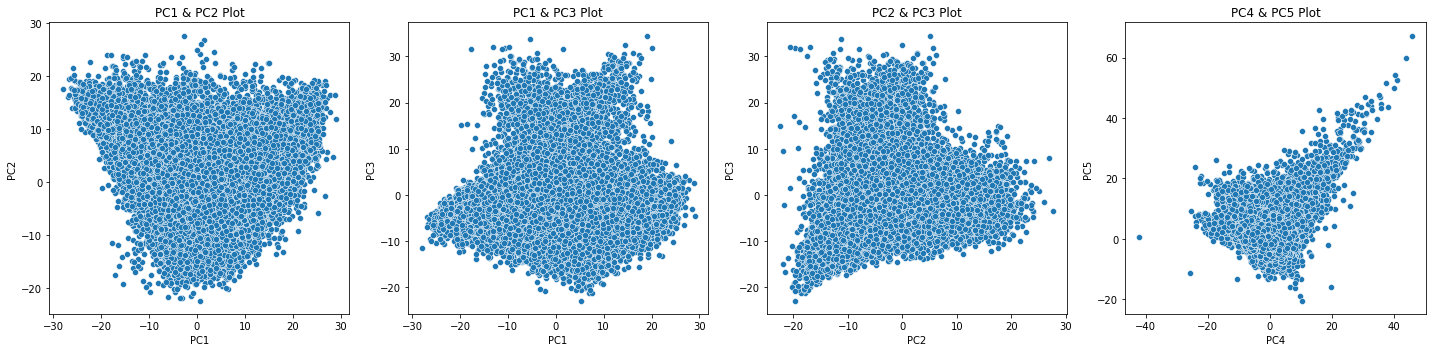

Text(0.5, 0.92, 'PCA 3D')

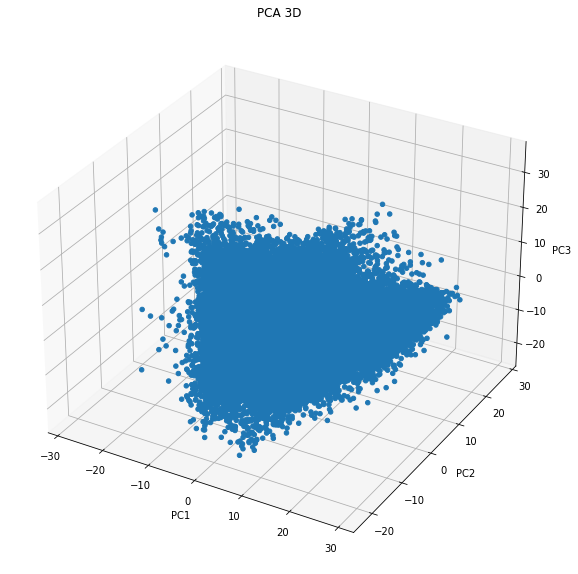

In [9]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
# sns.set(rc = {'figure.figsize':(15,8)})

sns.scatterplot(
    ax=axes[0],
    x="PC1", y="PC2",
    palette=sns.color_palette("icefire"),
    data=pca_df
)
axes[0].set_title("PC1 & PC2 Plot")
sns.scatterplot(
    ax=axes[1],
    x="PC1", y="PC3",
    palette=sns.color_palette("icefire"),
    data=pca_df
)
axes[1].set_title("PC1 & PC3 Plot")
sns.scatterplot(
    ax=axes[2],
    x="PC2", y="PC3",
    palette=sns.color_palette("icefire"),
    data=pca_df
)
axes[2].set_title("PC2 & PC3 Plot")

sns.scatterplot(
    ax=axes[3],
    x="PC4", y="PC5",
    palette=sns.color_palette("icefire"),
    data=pca_df
)
axes[3].set_title("PC4 & PC5 Plot")

plt.tight_layout()
plt.show()

ax = plt.figure(figsize=(16,10)).gca(projection='3d')
scatter_3d = ax.scatter(
    xs=pca_df['PC1'], 
    ys=pca_df['PC2'], 
    zs=pca_df['PC3'], 
    alpha = 1
)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title("PCA 3D")

## Section 3 - tSNE

In [10]:
'''
time_start = time.time()
tsne = opTSNE(
    n_components = 3,
    perplexity = 40,
    learning_rate = 'auto',
    early_exaggeration_iter = 50,
    early_exaggeration = 4,
    n_iter = 1000,
    initialization = 'random',
    initial_momentum = 0.5,
    final_momentum = 0.8,
    metric="euclidean",
    n_jobs=8,
    random_state=0,
    negative_gradient_method = 'barnes-hut',
    verbose=True,
)

%time tsne_results_op = tsne.fit(sample_only_scaled_data)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

np.save('op_tSNE_Results_' + 'Time_{}_seconds'.format(time.time()-time_start) , tsne_results)
'''

'\ntime_start = time.time()\ntsne = opTSNE(\n    n_components = 3,\n    perplexity = 40,\n    learning_rate = \'auto\',\n    early_exaggeration_iter = 50,\n    early_exaggeration = 4,\n    n_iter = 1000,\n    initialization = \'random\',\n    initial_momentum = 0.5,\n    final_momentum = 0.8,\n    metric="euclidean",\n    n_jobs=8,\n    random_state=0,\n    negative_gradient_method = \'barnes-hut\',\n    verbose=True,\n)\n\n%time tsne_results_op = tsne.fit(sample_only_scaled_data)\n\nprint(\'t-SNE done! Time elapsed: {} seconds\'.format(time.time()-time_start))\n\nnp.save(\'op_tSNE_Results_\' + \'Time_{}_seconds\'.format(time.time()-time_start) , tsne_results)\n'

In [11]:
# Util function for convert-to (0 - 1) range
def rescale(arr):
    arr_min = arr.min()
    arr_max = arr.max()
    return (arr - arr_min) / (arr_max - arr_min)
def rescale_AB(arr):
    arr_min = arr.min()
    arr_max = arr.max()
    return ( (arr - arr_min) / (arr_max - arr_min)  ) * 255 - 128

In [12]:
# Load the t-SNE results
op_tsne_results = np.load('op_tSNE_Results_Time_456.8306334018707_seconds.npy')

In [13]:
tsne_df = pd.DataFrame(data=op_tsne_results[:],columns=["tSNE_dim1","tSNE_dim2","tSNE_dim3"])
tsne_df['pixel_ID'] = samples_selected
tsne_df['L_Component'] = op_tsne_results[:,0]
tsne_df['A_Component'] = op_tsne_results[:,1]
tsne_df['B_Component'] = op_tsne_results[:,2]

In [14]:
LAB_mapping = [ tsne_df['L_Component'] , tsne_df['A_Component'] , tsne_df['B_Component'] ]
LAB_colors = np.asarray(LAB_mapping)
LAB_colors = LAB_colors.swapaxes(0,1)

L = rescale(LAB_colors[:,0]) * 100
A = rescale_AB(LAB_colors[:,1])
B = rescale_AB(LAB_colors[:,2])
LAB_colors = np.asarray( [ L , A, B ] )
LAB_colors = LAB_colors.swapaxes(0,1)
RGB_colors = lab2rgb(LAB_colors)


C:\Users\omars\anaconda3\lib\site-packages\skimage\color\colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 1504 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


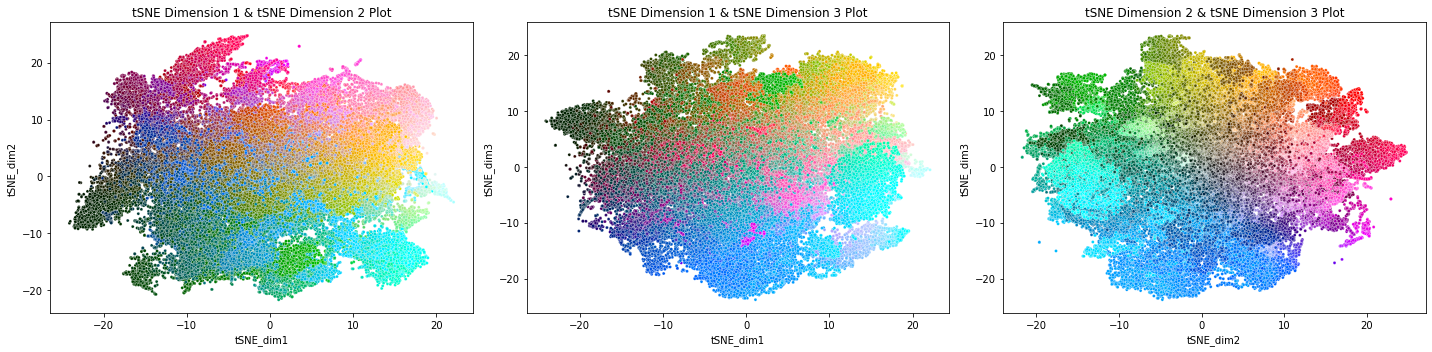

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
# sns.set(rc = {'figure.figsize':(15,8)})
marker_size = 9

sns.scatterplot(
    ax = axes[0],
    x = "tSNE_dim1", y="tSNE_dim2",
    c = RGB_colors,
    s = marker_size,
    data = tsne_df
)
axes[0].set_title("tSNE Dimension 1 & tSNE Dimension 2 Plot")

sns.scatterplot(
    ax = axes[1],
    x = "tSNE_dim1", y="tSNE_dim3",
    c = RGB_colors,
    s = marker_size,
    data = tsne_df
)
axes[1].set_title("tSNE Dimension 1 & tSNE Dimension 3 Plot")

sns.scatterplot(
    ax = axes[2],
    x = "tSNE_dim2", y="tSNE_dim3",
    c = RGB_colors,
    s = marker_size,
    data = tsne_df
)
axes[2].set_title("tSNE Dimension 2 & tSNE Dimension 3 Plot")



plt.tight_layout()
plt.show()



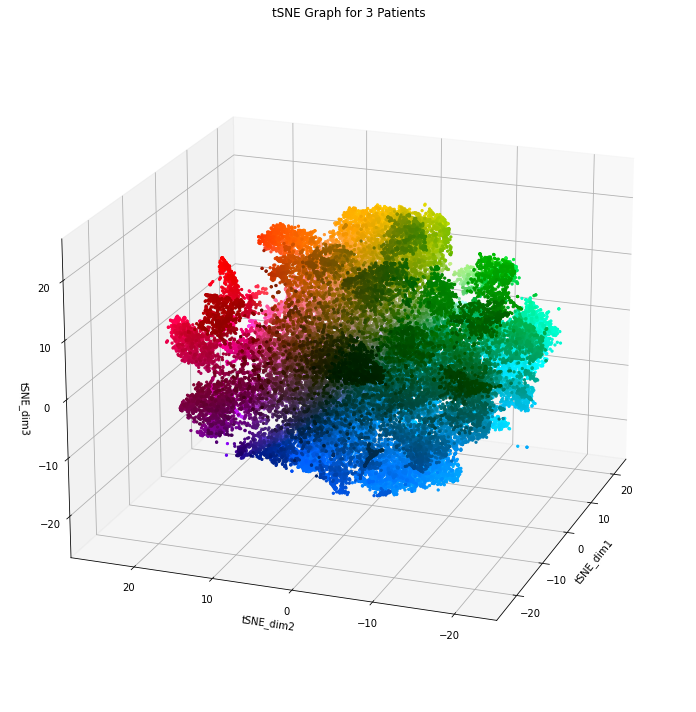

In [16]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
scatter_3d = ax.scatter(
    xs=tsne_df['tSNE_dim1'], 
    ys=tsne_df['tSNE_dim2'], 
    zs=tsne_df['tSNE_dim3'], 
    c = RGB_colors,
    s = 5,
    alpha = 1,
)

ax.set_xlabel('tSNE_dim1')
ax.set_ylabel('tSNE_dim2')
ax.set_zlabel('tSNE_dim3')
ax.set_title("tSNE Graph for 3 Patients")

fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

# elev is z-axis, +ve moves up, -ve moves down
# azim is x axis, +ve moves right, -ve moves left
ax.view_init(elev = 20 , azim = -160) 
plt.tight_layout()
